In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib.gridspec import GridSpec
import lightgbm as lgb
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
imputed_data = pd.read_csv("imputed_data_handle_multicollinearity.csv")
imputed_data=imputed_data.drop('Unnamed: 0',axis=1)
imputed_data.head()

,GrLivArea,SalePrice,OverallQual,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_Unknown,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y
0,1049.0,139500.0,5.0,1984.0,1984.0,552.0,393.0,104.0,1049.0,1049.0,...,0,0,0,1,0,0,0,0,1,1
1,1049.0,139500.0,5.0,1984.0,1984.0,552.0,393.0,104.0,1049.0,1049.0,...,0,0,0,1,0,0,0,0,0,1
2,1049.0,139500.0,5.0,1984.0,1984.0,552.0,393.0,104.0,1049.0,1049.0,...,0,0,0,1,0,0,0,0,1,1
3,1001.0,124900.0,5.0,1930.0,2007.0,737.0,0.0,100.0,837.0,1001.0,...,0,0,0,0,0,0,0,0,1,1
4,1001.0,124900.0,5.0,1930.0,2007.0,737.0,0.0,100.0,837.0,1001.0,...,0,0,0,1,0,0,0,0,0,1


Running KFold: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


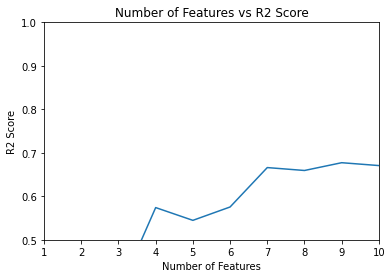

In [3]:
# Separate the independent variables (features) from the dependent variable (target)
X = imputed_data.drop('SalePrice', axis=1)
y = imputed_data['SalePrice']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the model for feature selection
selector_model = LassoCV(max_iter=10000, cv=5)

# Fit the model for feature selection
selector = SelectFromModel(selector_model)
selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[selector.get_support()].tolist()

# Select the selected features from the train and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Define the model for regression
model = MLPRegressor()

# Set up KFold with shuffle=True
kf = KFold(n_splits=5, shuffle=True)

# Initialize empty lists to store R2 scores
train_r2_scores = []
test_r2_scores = []

# Loop through the folds with a tqdm progress bar
for train_index, test_index in tqdm(kf.split(X_train_selected), total=kf.n_splits, desc='Running KFold'):
    X_train_fold, X_test_fold = X_train_selected.iloc[train_index], X_train_selected.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Fit the model on the selected features and calculate R2 on the train and test sets
    model.fit(X_train_fold, y_train_fold)
    train_r2 = model.score(X_train_fold, y_train_fold)
    test_r2 = model.score(X_test_fold, y_test_fold)
    
    # Append the R2 scores to the lists
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Plot the results
num_features_list = list(range(1, len(selected_features) + 1))
test_r2_list = []
for i in range(len(num_features_list)):
    selected_features_i = selected_features[:i+1]
    X_train_selected_i = X_train[selected_features_i]
    X_test_selected_i = X_test[selected_features_i]
    model.fit(X_train_selected_i, y_train)
    test_r2_i = model.score(X_test_selected_i, y_test)
    test_r2_list.append(test_r2_i)

plt.plot(num_features_list, test_r2_list)
plt.xlabel('Number of Features')
plt.ylabel('R2 Score')
plt.title('Number of Features vs R2 Score')
plt.xticks(range(1, len(selected_features)+1))
plt.ylim(0.5, 1)
plt.xlim(1,len(selected_features))
plt.show()

In [6]:
# Create a dataframe to store the results
results_df = pd.DataFrame({'importance_rank': range(1, len(selected_features)+1),
                           'feature_name': selected_features,
                           'test_r2': test_r2_list})

# Sort the dataframe by test_r2 in ascending order
results_df = results_df.sort_values(by='test_r2')

# Update the importance_rank column based on the sorted order
results_df['importance_rank'] = range(1, len(selected_features)+1)

# Print the ranked feature list
print(results_df[['importance_rank', 'feature_name', 'test_r2']])


   importance_rank  feature_name   test_r2
2                1  YearRemodAdd  0.379339
1                2     YearBuilt  0.418456
0                3     GrLivArea  0.469598
4                4    BsmtFinSF2  0.544723
3                5    BsmtFinSF1  0.574082
5                6     BsmtUnfSF  0.575454
7                7      1stFlrSF  0.659394
6                8   TotalBsmtSF  0.666077
9                9      PoolArea  0.670700
8               10    GarageArea  0.677276


In [7]:
# Save the results in the current working directory
results_df.to_csv('results_mlp.csv', index=False)